In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [75]:
# download CASIA-WebFace dataset if in COLAB

!gdown --id 1Of_EVz-yHV7QVWQGihYfvtny9Ne8qXVz -O CASIA-WebFace.zip
!unzip /content/CASIA-WebFace.zip
!rm /content/CASIA-WebFace.zip

TypeError: ignored

In [69]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import csv
import pandas as pd
import numpy as np
import os
import cv2
import glob
from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as T
from torchvision.io import read_image


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

In [5]:
data = []
needed = []

labels_paths = glob.glob('/content/CASIA-WebFace/' + '*')
n_labels = len(labels_paths)

for i in range(n_labels):
  data.append(glob.glob(labels_paths[i] + '/*.jpg'))
  
for i in range(n_labels - 1):
  needed.append([data[i][0], data[i][1], 1])

for i in range(n_labels - 1):
  needed.append([data[i][0], data[i + 1][0], 0])

In [6]:
with open('some.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerow(['img0', 'img1', 'relationshion'])
  writer.writerows(needed)


In [7]:
df = pd.read_csv('/content/some.csv')
df = df.sample(frac=1)
df.head()

,img0,img1,relationshion
21051,/content/CASIA-WebFace/1083389/004.jpg,/content/CASIA-WebFace/0061777/004.jpg,0
19515,/content/CASIA-WebFace/2316017/004.jpg,/content/CASIA-WebFace/1013239/004.jpg,0
17720,/content/CASIA-WebFace/0321621/004.jpg,/content/CASIA-WebFace/1703463/004.jpg,0
3266,/content/CASIA-WebFace/0000189/147.jpg,/content/CASIA-WebFace/0000189/004.jpg,1
15912,/content/CASIA-WebFace/2167817/004.jpg,/content/CASIA-WebFace/1836666/004.jpg,0


In [8]:
class CasiaWebFase(Dataset):
  def __init__(self, 
               path,
               csv_file,
               transform
               ):
    self.path = path
    self.relation_labels = pd.read_csv(csv_file)
    self.transform = transform
    
  def __getitem__(self, index):

    data = []
    labels_paths = glob.glob(self.path + "*")
    for label_path in labels_paths:
      labels_name = label_path.split("/")[-1]
      for img_path in glob.glob(label_path + '/*.jpg'):
        data.append([img_path, labels_name])

    self.relation_labels = self.relation_labels.sample(frac=1)
    
    img0 = read_image(self.relation_labels.iloc[index, 0])
    img1 = read_image(self.relation_labels.iloc[index, 1])
    relation = self.relation_labels.iloc[index, 2]

    if self.transform:
      img0 = self.transform(img0)
      img1 = self.transform(img1)
    
    return img0, img1, relation
    
  def __len__(self):
    return len(data)
    

In [48]:
transform = T.Compose([T.Resize((128,128)),
                       T.Grayscale()])

dataloader = DataLoader(CasiaWebFase('/content/CASIA-WebFace/',
                                     '/content/some.csv',
                                     transform),
                        batch_size = 20)

img0, img1, relation = next(iter(dataloader))


In [10]:
class mfm(nn.Module):
  def __init__(self, in_ch, out_ch, kernel_size = 3, stride = 1, padding = 1, type=1):
    super().__init__()
    self.out_ch = out_ch
    if type == 1:
      self.filter = nn.Conv2d(in_ch, 2 * out_ch, kernel_size, stride, padding)
    else:
      self.filter = nn.Linear(in_ch, 2 * out_ch)
  def forward(self, input):
    input = self.filter(input)
    output = torch.split(input, self.out_ch, 1)
    return torch.max(output[0], output[1])

In [11]:
class group(nn.Module):
  def __init__(self, in_ch, out_ch, kernel_size, stride, padding):
    super().__init__()
    self.conv_a = mfm(in_ch, in_ch, 1, 1, 0)
    self.conv = mfm(in_ch, out_ch, kernel_size, stride, padding)
  def forward(self, input):
    input = self.conv_a(input)
    output = self.conv(input)
    return output

In [28]:
class network_9layers(nn.Module):
  def __init__(self):
    super(network_9layers, self).__init__()
    self.features = nn.Sequential(
        mfm(1, 48, 5, 1, 2), 
        nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True), 
        group(48, 96, 3, 1, 1), 
        nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
        group(96, 192, 3, 1, 1),
        nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True), 
        group(192, 128, 3, 1, 1),
        group(128, 128, 3, 1, 1),
        nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
        )
    self.fc1 = mfm(8*8*128, 256, type=0)
    self.fc2 = nn.Linear(256, 256)

    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 1)

  def forward_once(self, input):

    input = self.features(input)
    input = input.view(input.size(0), -1)
    input = self.fc1(input)
    input = F.dropout(input, training=self.training)
    output = self.fc2(input)
    return output

  def forward(self, input1, input2):
    output1 = self.forward_once(input1)
    output2 = self.forward_once(input2)
    return output1, output2

In [33]:
class ContrastiveLoss(nn.Module):
  def __init__(self, margin):
    super().__init__()
    self.margin = margin
  def forward(self, img0, img1, label):
    euclidean_distance = F.pairwise_distance(img0, img1)
    loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
    return loss_contrastive


In [34]:
model = network_9layers()
criterion = ContrastiveLoss(margin=2.0)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epoch = 10

In [65]:
from torch.autograd import Variable

counter = []
loss_history = [] 
iteration_number = 0

for epoch in range(0, num_epoch):
  for i, data in enumerate(dataloader, 0):
    img0, img1 , label = data
    img0, img1 = img0.float(), img1.float()
    
    output1, output2 = model(img0, img1)
    optimizer.zero_grad()
    loss_contrastive = criterion(output1, output2, label)
    loss_contrastive.backward()
    optimizer.step()

    if i % 10 == 0 :
      print("Epoch number {}\n Current loss {}\n".format(epoch, loss_contrastive))
      iteration_number +=10
      counter.append(iteration_number)
      loss_history.append(loss_contrastive)

Epoch number 0
 Current loss 12.869988441467285

Epoch number 1
 Current loss 26.81017303466797

Epoch number 2
 Current loss 29.29948616027832

Epoch number 3
 Current loss 52.32004928588867

Epoch number 4
 Current loss 27.152936935424805

Epoch number 5
 Current loss 29.345178604125977

Epoch number 6
 Current loss 20.703916549682617

Epoch number 7
 Current loss 47.22914123535156

Epoch number 8
 Current loss 14.664618492126465

Epoch number 9
 Current loss 24.638051986694336



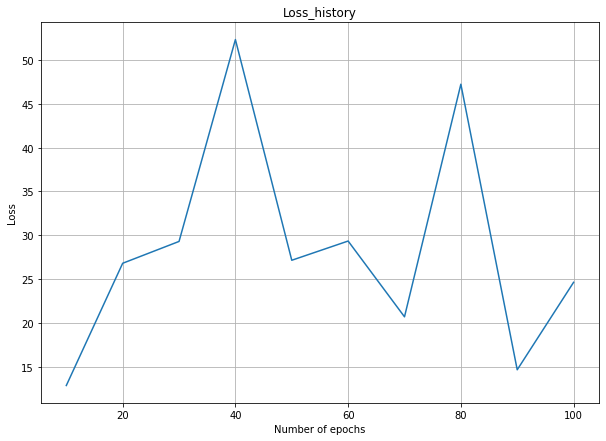

In [74]:
def loss_plot(counter, loss_history):
  plt.figure(figsize=(10, 7))
  plt.plot(counter, loss_history)
  plt.title('Loss_history')
  plt.xlabel('Number of epochs')
  plt.ylabel('Loss')
  plt.grid()

loss_plot(counter,loss_history)